# Saliency Tuning

In this notebook, we attempt to refine the saliency maps generated by the WideResnet22 model which achieved 95% accuracy on the EuroSat dataset, and was trained in `EuroSat-SaliencyComparison.ipynb`. This is necessary to explore the limitations and capabilities of these maps.

For example: what is the best way to scale these maps to work at such a fine resolution? EuroSat is 10m/pixel, Urban 3D is 50cm/pixel. That's a 20x difference in 1D, but that's gigantic.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import fastai
from fastai.vision import *
import torch
from scipy.ndimage.filters import gaussian_filter as gaussian_filter

# Image Loading Utilities

Here we create some variables that make loading data very clear and simple.
Categories are mapped to indices located in the file `cat2idx.txt`. The images from EuroSat are loaded in randomly.

In [2]:
datadir='../EuroSat/'
categories = []
cat2idx = {}
with open("cat2idx.txt", "r") as f:
    for line in f:
        cat, idx = line.strip().split(":")
        categories.append(cat)
        cat2idx[cat] = int(idx)
        print(datadir+cat, "exists:", os.path.isdir(datadir+cat))
        
fnames = []
labels = []
for cat in categories:
    for name in os.listdir(datadir+cat):
        fnames.append(name)
        labels.append(cat2idx[cat])
labels = np.array(labels)

def load_img(index):
    """Loads an image into memory based upon the index, by piecing together pathname
    from global variables (datadir, categories, labels, fnames)"""
    path2img = os.path.join(datadir, categories[labels[index]], fnames[index])
    # CV2 reads in images BGR, we want RGB
    bgr = cv2.imread(path2img, cv2.IMREAD_COLOR)
    return np.dstack((bgr[...,-1], bgr[...,1], bgr[...,0])) / 255.0

../EuroSat/Residential exists: True
../EuroSat/Pasture exists: True
../EuroSat/Industrial exists: True
../EuroSat/HerbaceousVegetation exists: True
../EuroSat/PermanentCrop exists: True
../EuroSat/SeaLake exists: True
../EuroSat/River exists: True
../EuroSat/AnnualCrop exists: True
../EuroSat/Forest exists: True
../EuroSat/Highway exists: True


### Load in WideResnet22

#### Quick Hack
Apparently fastai's model class is _super_ tightly linked to its dataset class `DataBunch`. So close, that both objects need to be saved, in order for model inference to work properly - I have no idea why this is. But, I managed to get around this by just restoring the `CLASS_ORDERING` list which allows us to recover the `DataBunch` object even though I forgot to save it.

In [3]:
CLASS_ORDERING = [
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'
]

In [4]:
tfms = get_transforms(max_warp=0.0) # Applies fast.ai's default transforms
data = (ImageItemList.from_folder(datadir, recurse=True)
        .random_split_by_pct() # Train/Validation is 0.8/0.2 % of dataset
        .label_from_folder()
        .transform(tfms)
        .databunch() # Make into Fast.ai's dataset object
        .normalize([torch.tensor(0.0), torch.tensor(255.0)]) # Set range 0-1
       )
data.classes = CLASS_ORDERING
wrn = Learner(data, models.wrn_22(), metrics=accuracy)

In [5]:
wrn.load("wrn22-95")

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (21600 items)
[Category Residential, Category Residential, Category Residential, Category Residential, Category Residential]...
Path: ../EuroSat
x: ImageItemList (21600 items)
[Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64)]...
Path: ../EuroSat;

Valid: LabelList
y: CategoryList (5400 items)
[Category Forest, Category Industrial, Category SeaLake, Category Residential, Category SeaLake]...
Path: ../EuroSat
x: ImageItemList (5400 items)
[Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64)]...
Path: ../EuroSat;

Test: None, model=WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

#### Saliency Map Utilities

In [6]:
def make_torch(img):
    if len(img.shape) == 4:
        img = np.transpose(img, (0, 3, 1, 2))
    elif len(img.shape) == 3:
        img = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)
    else:
        raise ValueError("img needs to be rank 3 or rank 4 tensor")
    return torch.Tensor(img)

In [7]:
def make_sal(model, tensor, truth, loss, abs=True):
    tensor = torch.autograd.Variable(tensor, requires_grad=True)
    out = model(tensor.cuda())
    # It took forever to figure out that .long() was required
    L = loss(out, truth.long().cuda())
    L.backward()
    grad = tensor.grad.data.detach().cpu().numpy()
    return np.abs(grad).max(axis=1).squeeze()

#### Reviewing WideResnet's Performance

Seems to nail it!

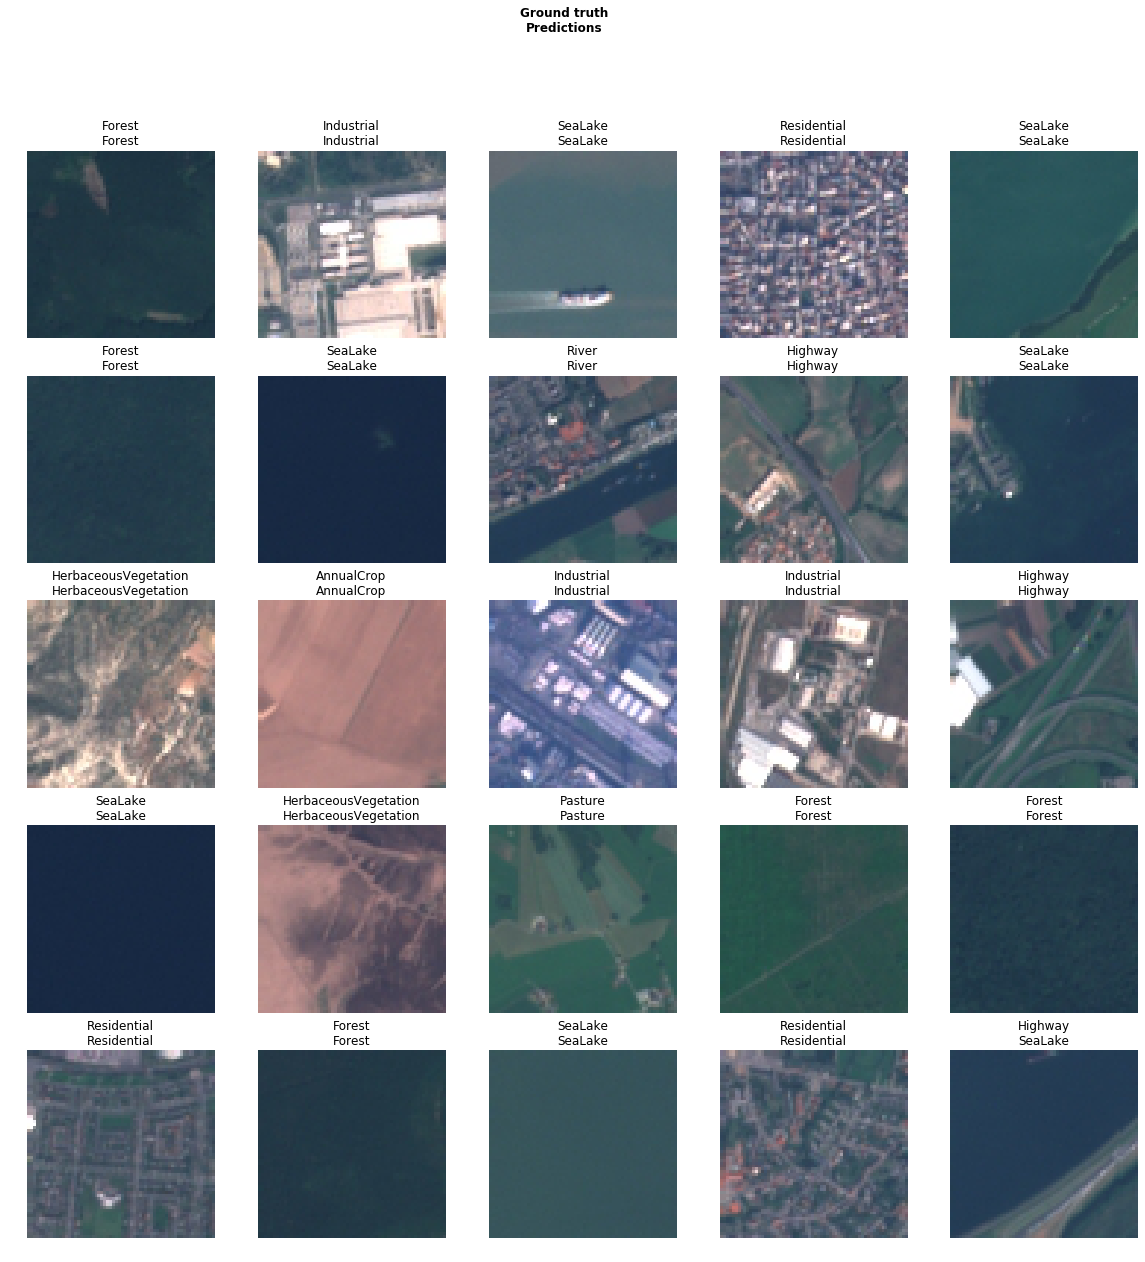

In [8]:
wrn.show_results()

# Visualizing its saliency maps

The only difference is that here, we remove edge artifacts from the saliency maps, and then resize by a factor of 20x in each dimension.

Here, I realized I made a mistake. I accidentally normalized the pixels between 0-1/255, instead of between 0-1. Well, just have to remember that going forward.

Truth is: HerbaceousVegetation


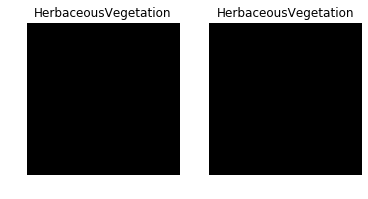

In [9]:
idx = np.random.choice(len(labels))
img = load_img(idx)
q = normalize(make_torch(img), torch.Tensor([0]), torch.Tensor([255.0]))
fig, ax = plt.subplots(ncols=2)
for x in ax: x.axis("off")
    
with torch.no_grad():
    out = wrn.model(make_torch(img / 255.0).cuda())
    ax[0].set_title(f"{CLASS_ORDERING[out.squeeze().argmax()]}")
    out = wrn.model(q.cuda())
    ax[1].set_title(f"{CLASS_ORDERING[out.squeeze().argmax()]}")
    print(f"Truth is: {categories[labels[idx]]}")
ax[0].imshow(img / 255.0)
ax[1].imshow(np.transpose(q.numpy().squeeze(), (1,2,0)))

Here, we can see what happens when we change loss parameters as we generate the saliency map. This shows that there is some variability between which class we choose to backprop from.

In [10]:
def clean_up(img, border=5):
    """Replaces img border with reflected border"""
    cropped = img[border:-border, border:-border]
    return cv2.copyMakeBorder(cropped, border, border, border, border, cv2.BORDER_REFLECT)

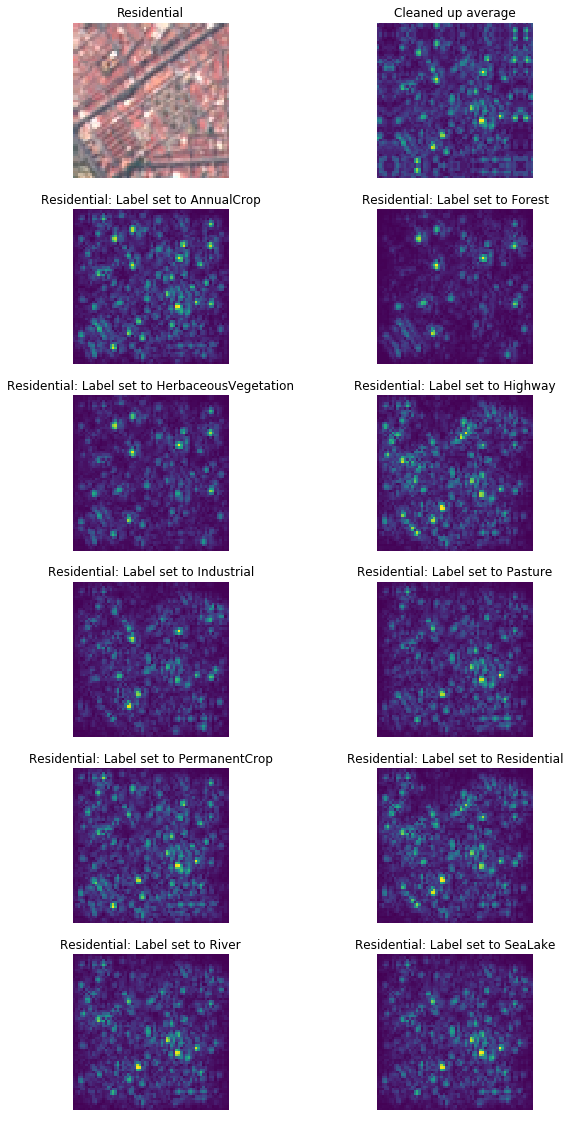

In [11]:
def plot_tuning(idx):
    fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(10,20))
    ax[0,0].axis("off")
    ax[0,0].imshow(load_img(idx))
    ax[0,0].set_title(f"{categories[labels[idx]]}")
    # fig.delaxes(ax[0,1])
    avgd = np.zeros((64,64))
    for i, x in enumerate(ax[1:].flatten()):
        input_tensor = make_torch(load_img(idx) / 255.0).cuda()
        sal = make_sal(wrn.model, input_tensor, torch.Tensor([i]).cuda(), wrn.loss_func.func)
        avgd = avgd + sal / 10.0
        x.imshow(sal)
        x.axis("off")
        with torch.no_grad():
            out = wrn.model(input_tensor)
            selection = out.squeeze().argmax()
            x.set_title(f"{CLASS_ORDERING[selection]}: Label set to {CLASS_ORDERING[i]}")
    ax[0,1].imshow(clean_up(avgd))
    ax[0,1].axis("off")
    ax[0,1].set_title("Cleaned up average")

idx = np.random.choice(len(labels))
plot_tuning(idx)

#### Trying to clean up the saliency map by averaging across all losses (plots above)

First, we try replacing a 5 pixel border of the saliency map with a reflected 5 pixel border. Then we try Gaussian blurring, but the result doesn't seem to make much sense.

6.511903 1968.8408


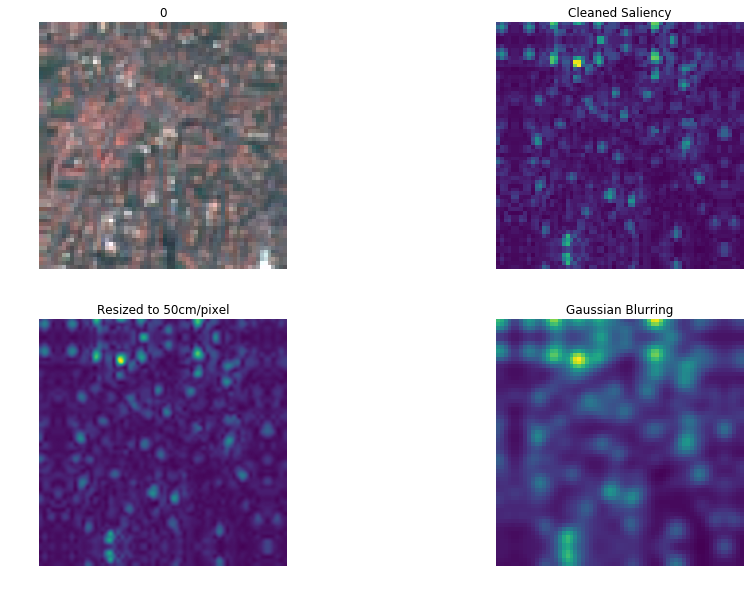

In [12]:
sal = clean_up(make_sal(wrn.model, make_torch(load_img(0)/255.0),
                        torch.Tensor([1]).cuda(),
                        wrn.loss_func.func))
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=2)
for x in axes.flatten():
    x.axis("off")
left,right = axes[0]
left.imshow(load_img(0))
left.set_title(labels[0])
right.imshow(sal)
right.set_title("Cleaned Saliency")
ll, lr = axes[1]
ll.imshow(cv2.resize(sal, (20*64, 20*64), interpolation=cv2.INTER_CUBIC))
ll.set_title("Resized to 50cm/pixel")
lr.imshow(gaussian_filter(sal, 1.5))
lr.set_title("Gaussian Blurring")
print(sal.min(), sal.max())

# Creating Saliency Maps from Urban 3D

2 Datasets finally making contact. Here, we are just reloading our utilities for getting the tiff files.

In [13]:
import georaster
import gdal

def load_tiff(src, tiff=False):
    has_alpha = 0
    src_ds = gdal.Open(src, gdal.GA_ReadOnly)
    if tiff:
        return src_ds
    last_channel = src_ds.RasterCount + (1 if not has_alpha else 0)
    arr = [src_ds.GetRasterBand(idx).ReadAsArray() for idx in range(1, last_channel)]
    return np.dstack(arr)


traindir = '../Train/Inputs/'
truthdir = '../Train/GT/'
# Gets RGB names
names = list([name for name in os.listdir(traindir) if name[-7:] == 'RGB.tif' ])

I'm curious as to what the range of values for depth mappings in our train data are.

In [14]:
maxs = [0, 0, 0]
mins = [1e3, 1e3, 1e3]
min_fs = [0]*3
max_fs = [0]*3
for idx in range(len(names)):
    dsm = load_tiff(traindir+names[idx].replace("RGB","DSM"))
    dtm = load_tiff(traindir+names[idx].replace("RGB","DTM"))
    dem = dsm - dtm
    for i,arr in enumerate([dsm, dtm, dem]):
        if maxs[i] < arr.max():
            maxs[i] = arr.max()
            max_fs[i] = names[idx]
        if mins[i] > arr.min():
            mins[i] = arr.min()
            min_fs[i] = names[idx]
for name, big, small, max_f, min_f in zip(["DSM", "DTM", "DEM"], maxs, mins, max_fs, min_fs):
    print(f"{name} min:{small:<6.2f}\tmax:{big:<6.2f}\t{min_f}\t{max_f}")

DSM min:-32767.00	max:160.12	TAM_Tile_011_RGB.tif	JAX_Tile_041_RGB.tif
DTM min:-32767.00	max:8.28  	TAM_Tile_011_RGB.tif	JAX_Tile_010_RGB.tif
DEM min:-11.26	max:184.26	JAX_Tile_041_RGB.tif	JAX_Tile_041_RGB.tif


Since DEM (normalized surface) is between (-12, 185), I'll probably avoid emulating this range of values with the saliency maps. 

#### Surprise! Saliency Maps Look Useful

Here, we choose to visualize saliency maps on the tiff file with the smallest normalized DEM value in our training data. In our first attempt, we load in the tiff in the proper range for our model, which is 0-1/255. These maps look sparse and unhelpful. However, in the next plot, we use the 0-1 range, and the maps look great!

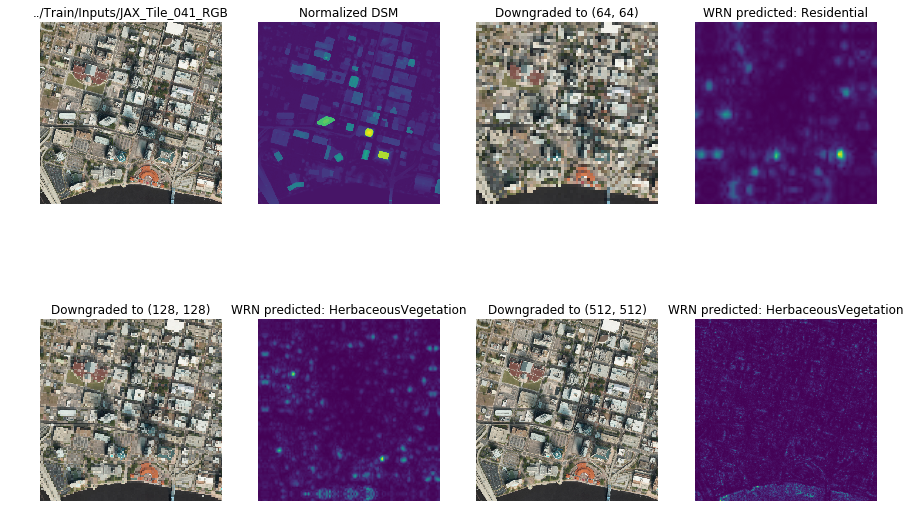

In [15]:
curr_name = traindir+min_fs[-1]

def plot_file_and_sal_size(curr_name, model, sizes, target=1.0, factor=255.0):
    """Sizes is a length 3 array of 2-tuples, factor=255.0 means use a value range
    that will work with the WRN model"""
    img = load_tiff(curr_name) / 255.0
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
    # Remove ticks & spines
    for x in ax.flatten():
        x.axis("off")
    left, right = ax[0,:2]
    # Plot image & depth mapping as first 2 plots
    left.imshow(img)
    left.set_title(curr_name[:-4])
    dsm = load_tiff(curr_name.replace("RGB","DSM"))
    dtm = load_tiff(curr_name.replace("RGB","DTM"))
    dem = dsm - dtm
    right.imshow(dem.squeeze())
    right.set_title("Normalized DSM")
    del(dsm, dtm, dem)
    for i, x in enumerate(ax.flatten()[2:]):
        if i % 2 == 0:
            x.set_title(f"Downgraded to {sizes[i//2]}")
            x.imshow(cv2.resize(img, sizes[i//2]))
        else:
            sal = make_sal(model.model, 
                           make_torch(cv2.resize(img / factor, 
                                    sizes[i//2])),
                           torch.Tensor([target]).cuda(), 
                           model.loss_func.func)
            with torch.no_grad():
                model.model.zero_grad()
                out = model.model(make_torch(cv2.resize(img / factor, sizes[i//2])).cuda())
            x.set_title(f"WRN predicted: {CLASS_ORDERING[out.squeeze().argmax()]}")
            x.imshow(cv2.resize(clean_up(sal), (2048, 2048)))

sizes = [(64, 64), (128, 128), (512, 512)]
plot_file_and_sal_size(curr_name, wrn, sizes, target=1.0, factor=255.0)

In this next attempt to plot saliency maps, we blow the range up to \[0,1\] as usual. This happened by accident initially. It took careful debugging to realize what had happened-but what a useful accident!

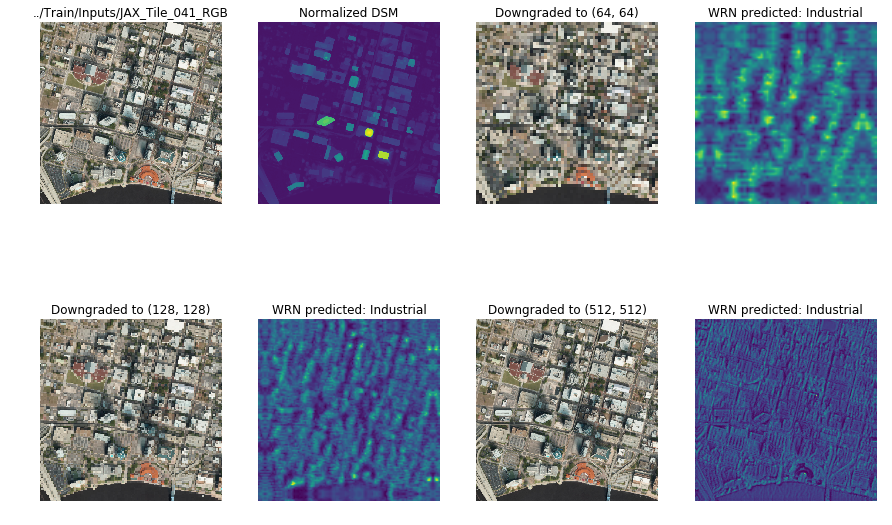

In [16]:
plot_file_and_sal_size(curr_name, wrn, sizes, factor=1)

### Resizing the Saliency Map

Because the "improper" saliency map (whose input was in \[0,1\]) looks more promising than the other "proper" saliency map, we'll investigate the improper one first. Here, we attempt to create a saliency map at 50cm/pixel in a 2048x2048 space.

In [103]:
def get_saliency_big(model, input_tensor, truth, loss, step=512, factor=1.0, verbose=False):
    """Takes in input tensor of size [4, 2048, 2048]"""
    preds = []
    input_tensor = input_tensor / factor
    for x in range(0, input_tensor.shape[-2], step):
        for y in range(0, input_tensor.shape[-1], step):
            cut = input_tensor[..., x:x+step, y:y+step]
            preds.append(clean_up(make_sal(model, cut,
                                     truth, loss)))
    num_steps = input_tensor.shape[-1] // step
    rows = []
    # bind matrices into rows
    for i in range(0,len(preds),num_steps):
        row = np.concatenate(preds[i:i+num_steps], axis=1)
        rows.append(row)
    # bind rows into matrix
    sal = np.concatenate(rows, axis=0)
    return sal

Now, we plot the result on the same exact file we used above.

In [48]:
img = load_tiff(traindir+names[0])

In [49]:
sal = get_saliency_big(wrn.model, make_torch(img), torch.Tensor([1]), wrn.loss_func.func)

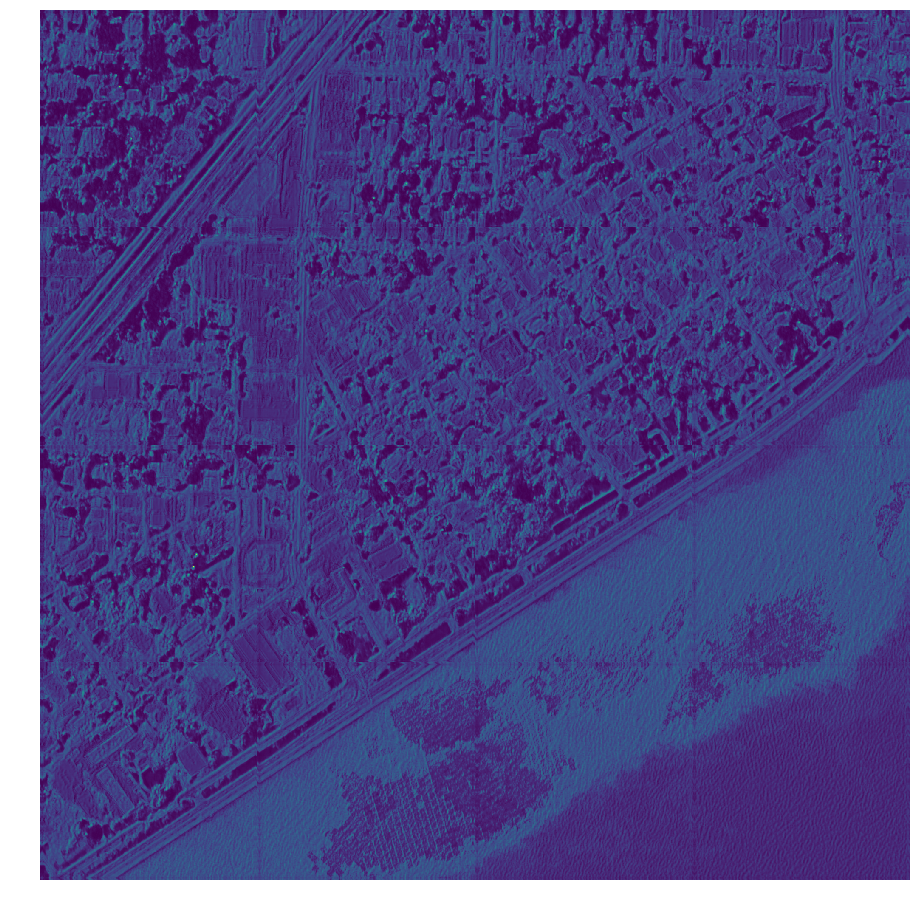

In [50]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(sal)

Looks like the original picture, which is honestly, kind of expected. We would expect the gradient to be highly correlated with the L2 distance of each pixel. You can see this when observing the orange ampitheatre, which appears dark black in this "improper saliency map."

Below, we plot an actual saliency map, and observe that it is very sparse, but seems to correlate its intensity depending upon whether it can find buildings, rivers, crops, etc in different regions of the image.

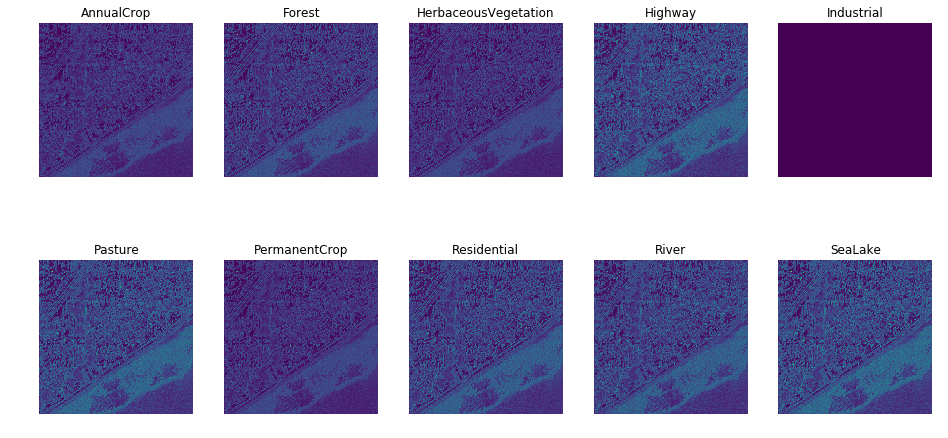

In [52]:
fig, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=5)
for i, x in enumerate(ax.flatten()):
    proper_sal = get_saliency_big(wrn.model, make_torch(img), 
                            torch.Tensor([i]), wrn.loss_func.func, factor=255.0)
    x.axis("off")
    x.set_title(f"{CLASS_ORDERING[i]}")
    x.imshow(proper_sal)

For reference, we plot the absolute value of the original image. This just looks like a better version of the saliency maps. I'm not quite sure if the saliency maps will be as useful as hoped for.

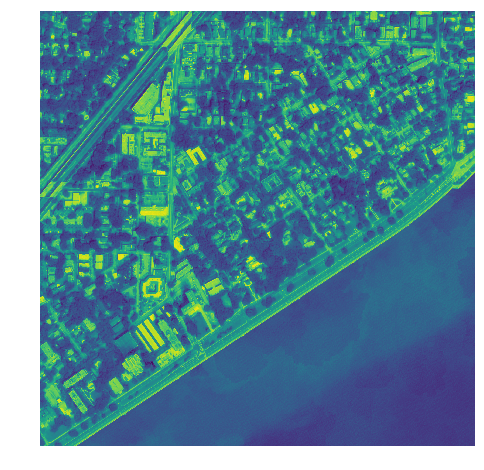

In [53]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img.max(axis=-1))

But for now we'll just save the "improper saliency masks" to disk (without gdal data). Next up, retraining albu's model with saliency maps.

In [110]:
def sal_from_file(fname, model, loss, truth=torch.Tensor([1]), **kwargs):
    img = load_tiff(fname) / 255.0
    sal = get_saliency_big(model, make_torch(img), truth, loss, **kwargs)
    return sal

One more sanity, check just random plotting. Looks dismal-not sure what these maps bring to the table, but it's still worth trying.

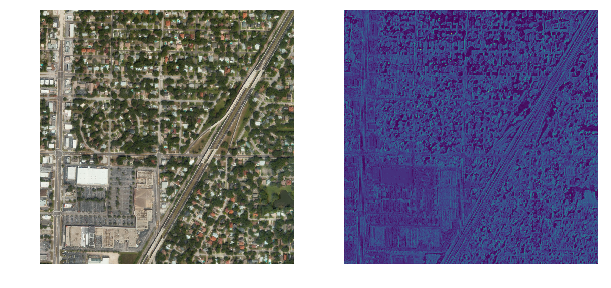

In [58]:
fig, axs = plt.subplots(figsize=(10,8), ncols=2)
rand = np.random.choice(names)
left, right = axs
left.axis("off"); right.axis("off")
left.imshow(load_tiff(traindir+rand))
right.imshow(sal_from_file(traindir+rand, wrn.model, wrn.loss_func.func))

In [59]:
from tqdm import tqdm

In [108]:
def save_sal_dir(givendir, ext='RGB.tif', destdir=None, **kwargs):
    for name in tqdm(os.listdir(givendir)):
        if name.endswith(ext):
            sal = sal_from_file(givendir+name, wrn.model, wrn.loss_func.func, step=325, **kwargs)
            new_name = name[:-len(ext)] + "SAL.npy"
            if not destdir:
                destdir = givendir
            os.makedirs(destdir, exist_ok=True)
            np.save(destdir+new_name, sal)

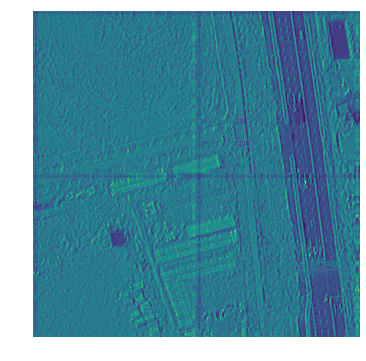

In [122]:
givendir='/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/'
names = os.listdir(givendir)
sal = sal_from_file(givendir+names[0], wrn.model, wrn.loss_func.func, step=325, factor=1)

plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(sal)

In [123]:
save_sal_dir('/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/', 
             ext='.tif', destdir='Shanghai-Sals/')

100%|██████████| 4582/4582 [49:35<00:00,  1.54it/s]


In [ ]:
save_sal_dir(traindir)
save_sal_dir(truthdir)
save_sal_dir("../Test/Inputs/")